# Imports and General Settings

In [2]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/device:GPU:0


# Data Augmentation

In [3]:
# data augmentation methods in data_augmentation_utility.py

def augment_image(image):
                       
    image = da_util.rotate(image)
    image = da_util.flip(image)
    
    image = da_util.translate(image)
    image = da_util.crop(image)

    return image

# ResNet

## ResNet-10 Architecture

In [75]:
num_classes = 3

# ResNet-10 architecture
def resnet10_network(x, conv_kernel=7, resblock_kernel=3, num_channels=4, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('Resnet-10', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.conv(x, num_channels, kernel=conv_kernel, stride=1, padding='SAME')
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock1_id1')      
   
        filtered_images.append(tf.identity(x))

        x = model_arch.resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                     downsample=True, scope='resblock2_conv1')
        
        filtered_images.append(tf.identity(x))

        x = model_arch.resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock3_id2')
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, 
                     downsample=True, scope='resblock4_conv2')

        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock5_id3')
        
        filtered_images.append(tf.identity(x))
        
        
        x = model_arch.batch_norm(x, is_training, scope='batch_norm')
        
        x = model_arch.relu(x)
        
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def resnet10_model_fn(features, labels, mode, conv_kernel=7, resblock_kernel=3, num_channels=4, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = resnet10_network(features,
                                                          conv_kernel=conv_kernel,
                                                          resblock_kernel=resblock_kernel,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)

        logits_test, activ_maps_test, _ = resnet10_network(features,
                                                        conv_kernel=conv_kernel,
                                                        resblock_kernel=resblock_kernel,
                                                        num_channels=num_channels,
                                                        n_classes=num_classes,
                                                        reuse=True,
                                                        is_training=False)

        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        tf.summary.scalar("loss", loss_op)
        tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

            conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

            plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
            tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                level_dict = {0 : "0_original_image",         
                              1 : "1_after_initial_conv",
                              2 : "2_after_resblock1_id1",
                              3 : "3_after_resblock2_conv1",
                              4 : "4_after_resblock3_id2",
                              5 : "5_after_resblock4_conv2",
                              6 : "6_after_resblock5_id3"}

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, level_dict[counter]), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 1)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## ResNet Experimentation

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

resnet4_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [3, 5, 7, 9]
filter_sizes = [8]
snnl_weights = [0.00]

data_root = "./data/data_relabeled_png/"

image_paths = load_image_paths(data_root)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)

train_input_fn = lambda : load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
eval_input_fn = lambda : load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
test_input_fn = lambda : load(data_root, test_paths, training=False, augment=False, shuffle=False)

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet4_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"
            print(model_path)

            config = tf.estimator.RunConfig(
                log_step_count_steps= 20,
                save_summary_steps= 30,
                save_checkpoints_secs= 120,
                model_dir=model_path,
                tf_random_seed=random_seed,
                session_config=session_config)

            model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=False)

            model = tf.estimator.Estimator(model_fn=model_fn, config=config)

            train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
            eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=120)

            tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
        
        

/data/jma/model/relabeled_data/resnet4/kernel3_filter8_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/relabeled_data/resnet4/kernel3_filter8_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4103d2b2e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and eval

INFO:tensorflow:Saving dict for global step 1116: accuracy = 0.66033256, global_step = 1116, loss = 34.8256
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1116: /data/jma/model/relabeled_data/resnet4/kernel3_filter8_snnl0.0/model.ckpt-1116
INFO:tensorflow:global_step/sec: 2.27878
INFO:tensorflow:loss = 0.0, step = 1120 (8.777 sec)
INFO:tensorflow:global_step/sec: 4.673
INFO:tensorflow:loss = 0.0, step = 1140 (4.280 sec)
INFO:tensorflow:global_step/sec: 4.62494
INFO:tensorflow:loss = 0.0, step = 1160 (4.324 sec)
INFO:tensorflow:global_step/sec: 4.77318
INFO:tensorflow:loss = 0.0, step = 1180 (4.192 sec)
INFO:tensorflow:global_step/sec: 4.59279
INFO:tensorflow:loss = 0.0, step = 1200 (4.354 sec)
INFO:tensorflow:global_step/sec: 4.63846
INFO:tensorflow:loss = 0.0, step = 1220 (4.311 sec)
INFO:tensorflow:global_step/sec: 4.62069
INFO:tensorflow:loss = 0.0, step = 1240 (4.328 sec)
INFO:tensorflow:global_step/sec: 4.66759
INFO:tensorflow:loss = 0.0, step = 1260 (4.287 sec)


INFO:tensorflow:global_step/sec: 4.69336
INFO:tensorflow:loss = 0.0, step = 2460 (4.262 sec)
INFO:tensorflow:global_step/sec: 4.59618
INFO:tensorflow:loss = 0.0, step = 2480 (4.350 sec)
INFO:tensorflow:global_step/sec: 4.67491
INFO:tensorflow:loss = 0.0, step = 2500 (4.278 sec)
INFO:tensorflow:global_step/sec: 4.6001
INFO:tensorflow:loss = 0.0, step = 2520 (4.349 sec)
INFO:tensorflow:global_step/sec: 4.73191
INFO:tensorflow:loss = 0.0, step = 2540 (4.228 sec)
INFO:tensorflow:global_step/sec: 4.60062
INFO:tensorflow:loss = 0.0, step = 2560 (4.345 sec)
INFO:tensorflow:global_step/sec: 4.67735
INFO:tensorflow:loss = 0.0, step = 2580 (4.277 sec)
INFO:tensorflow:global_step/sec: 4.62807
INFO:tensorflow:loss = 0.0, step = 2600 (4.320 sec)
INFO:tensorflow:global_step/sec: 4.66144
INFO:tensorflow:loss = 0.0, step = 2620 (4.291 sec)
INFO:tensorflow:global_step/sec: 4.60579
INFO:tensorflow:loss = 0.0, step = 2640 (4.343 sec)
INFO:tensorflow:global_step/sec: 4.73404
INFO:tensorflow:loss = 0.0, st

in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-01-01:16:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/relabeled_data/resnet4/kernel3_filter8_snnl0.0/model.ckpt-3810
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Finished evaluation at 2019-08-01-01:16:14
INFO:tensorflow:Saving dict for global step 3810: accuracy = 0.66033256, global_step = 3810, loss = 34.8256
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3810: /data/jma/model/relabeled_data/resnet4/kernel3_filter8_snnl0.0/model.ckpt-3810
INFO:tensorflow:global_step/sec: 2.27513
INFO:tensorflow:loss = 0.0, step = 3820 (8.791 sec)
INFO:tensorflow:global_step/sec: 4.75984
INFO:tensorflow:loss = 0.0, step = 3840 (4.203 sec)
INFO:tensorflow:global_step/sec: 4.76232
INFO:tensorflow:loss = 0.0, step = 3860 (4.199 sec)
INFO:tensorflow:g

INFO:tensorflow:loss = 0.0, step = 5060 (4.300 sec)
INFO:tensorflow:global_step/sec: 4.59818
INFO:tensorflow:loss = 0.0, step = 5080 (4.350 sec)
INFO:tensorflow:global_step/sec: 4.70463
INFO:tensorflow:loss = 0.0, step = 5100 (4.252 sec)
INFO:tensorflow:global_step/sec: 4.75556
INFO:tensorflow:loss = 0.0, step = 5120 (4.206 sec)
INFO:tensorflow:global_step/sec: 4.73976
INFO:tensorflow:loss = 0.0, step = 5140 (4.218 sec)
INFO:tensorflow:global_step/sec: 4.59024
INFO:tensorflow:loss = 0.0, step = 5160 (4.358 sec)
INFO:tensorflow:global_step/sec: 4.70835
INFO:tensorflow:loss = 0.0, step = 5180 (4.246 sec)
INFO:tensorflow:global_step/sec: 4.62715
INFO:tensorflow:loss = 0.0, step = 5200 (4.323 sec)
INFO:tensorflow:global_step/sec: 4.62791
INFO:tensorflow:loss = 0.0, step = 5220 (4.322 sec)
INFO:tensorflow:global_step/sec: 4.64914
INFO:tensorflow:loss = 0.0, step = 5240 (4.301 sec)
INFO:tensorflow:global_step/sec: 4.68576
INFO:tensorflow:loss = 0.0, step = 5260 (4.270 sec)
INFO:tensorflow:gl

Experimentation

## Evaluation

In [80]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet10/no_augment_255_norm/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [5]
filter_sizes = [8]
snnl_weights = [0.0]

data_root = "./data/custom_activation_map_data/"

image_paths = load_image_paths(data_root)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


eval_input_fn = lambda : load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"
            print(model_path)

            model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/relabeled_data/resnet10/no_augment_255_norm/kernel5_filter8_snnl0.0/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/relabeled_data/resnet10/no_augment_255_norm/kernel5_filter8_snnl0.0/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3f4c782128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_re

# Metrics

## Metric Utility Functions

In [78]:
def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels

print(eval_paths[:20])


['data/data_relabeled_png/1/IM-0012-0005-0001.dcm.png', 'data/data_relabeled_png/1/IM-0069-0023-0001.dcm.png', 'data/data_relabeled_png/1/IM-0046-0027-0001.dcm.png', 'data/data_relabeled_png/1/IM-0064-0014-0001.dcm.png', 'data/data_relabeled_png/2/IM-0054-0018-0001.dcm.png', 'data/data_relabeled_png/1/IM-0068-0022-0001.dcm.png', 'data/data_relabeled_png/1/IM-0053-0026-0001.dcm.png', 'data/data_relabeled_png/1/IM-0050-0004-0001.dcm.png', 'data/data_relabeled_png/1/IM-0003-0001-0001.dcm.png', 'data/data_relabeled_png/2/IM-0016-0001-0001.dcm.png', 'data/data_relabeled_png/1/IM-0071-0022-0001.dcm.png', 'data/data_relabeled_png/1/IM-0042-0009-0001.dcm.png', 'data/data_relabeled_png/2/IM-0005-0018-0001.dcm.png', 'data/data_relabeled_png/1/IM-0032-0031-0001.dcm.png', 'data/data_relabeled_png/0/IM-0004-0004-0001.dcm.png', 'data/data_relabeled_png/1/IM-0054-0006-0001.dcm.png', 'data/data_relabeled_png/1/IM-0031-0016-0001.dcm.png', 'data/data_relabeled_png/1/IM-0047-0024-0001.dcm.png', 'data/dat

## Confusion Matrices

/data/jma/model/relabeled_data/resnet4/kernel3_filter8_snnl0.0/
in gpu part


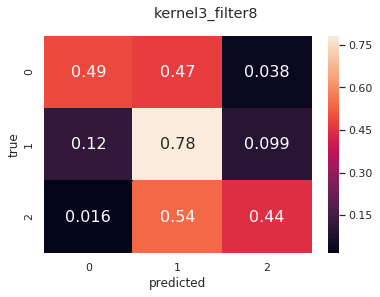

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


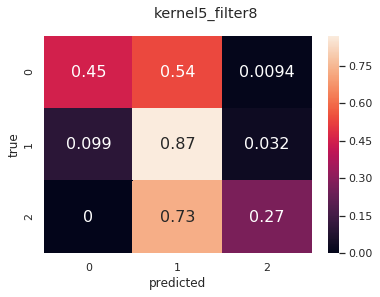

/data/jma/model/relabeled_data/resnet4/kernel7_filter8_snnl0.0/
in gpu part


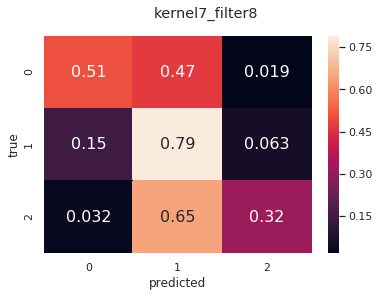

In [81]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

kernel_sizes = [3,5,7]
filter_sizes = [8]
snnl_weights = [0.00]

data_path = "./data/data_relabeled_png/"

random_seed = 777

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)



eval_input_fn = lambda : load(data_path, eval_paths, training=False, augment=False, shuffle=False, batch_size=64)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()

            title = "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)
            
            model_path = resnet10_checkpoint_path_base + title +"/"
            print(model_path)
        
        
            model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size)
            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            values = model.predict(eval_input_fn)


            original_labels = path_to_label(eval_paths, data_path)
            predicted_labels = list(values)

            cm = tf.confusion_matrix(original_labels, predicted_labels)
            cm = tf.to_float(cm)

            cm = cm.numpy()
            
            row_sums = cm.sum(axis=1)
            cm = cm / row_sums[:, np.newaxis]
            
            df_cm = pd.DataFrame(cm, range(3), range(3))
            #plt.figure(figsize = (10,7))

            sns.set(font_scale=1)#for label size
            plt.suptitle("kernel" + str(kernel_size) + "_filter" + str(filter_size))
            ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
            ax.set(xlabel='predicted', ylabel='true')
            plt.show()
        

## Incorrectly Classified Images (PNG Format)

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


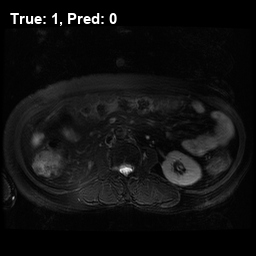

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

data_path = "./data/data_relabeled_png//"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
snnl_weight=0.0
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    